# InfoGAN Illustrated: Unsupervised Discovery of Interpretable Factors

This notebook demonstrates **Information Maximizing Generative Adversarial Networks (InfoGAN)** on 2D ellipse data. InfoGAN learns to **disentangle latent factors without supervision**, discovering interpretable representations automatically.

## Table of Contents
1. [Introduction & Theory](#theory)
2. [Data Generation](#data)
3. [InfoGAN Architecture](#model)
4. [Training Process](#training)
5. [Disentanglement Visualization](#disentanglement)
6. [Quantitative Evaluation](#evaluation)
7. [Interactive Experiments](#experiments)
8. [Comparison: InfoGAN vs Vanilla GAN vs cGAN](#comparison)
9. [Key Takeaways](#takeaways)

---
## 1. Introduction & Theory

### The Problem: Entangled Representations

In vanilla GANs, the latent code $z$ is typically sampled from a simple distribution (e.g., Gaussian), but the relationship between $z$ and the generated data's semantic features is **entangled** and **uninterpretable**.

For example, changing one dimension of $z$ might affect multiple attributes simultaneously (rotation + size + position), making it impossible to control individual factors.

### InfoGAN Solution: Disentangled Latent Codes

**InfoGAN** decomposes the latent code into:
- **Incompressible noise** $z$ ~ $P(z)$ (standard Gaussian)
- **Latent codes** $c$ ~ $P(c)$ that capture **interpretable semantic features**

The generator becomes: $G(z, c)$

### Key Idea: Maximize Mutual Information

InfoGAN maximizes the **mutual information** between latent codes $c$ and generated data $G(z, c)$:

$$
I(c; G(z, c)) = H(c) - H(c | G(z, c))
$$

This forces the generator to use the latent codes $c$ meaningfully - the generated samples must contain information about $c$.

### The Complete Objective

$$
\min_{G,Q} \max_D V_I(D, G, Q) = V(D, G) - \lambda I(c; G(z, c))
$$

where:
- $V(D, G)$ is the standard GAN objective
- $\lambda$ balances the mutual information term (typically $\lambda = 1$)
- $Q$ is an auxiliary network that approximates $P(c | x)$

### Variational Lower Bound

Since $I(c; G(z,c))$ is hard to compute directly, we use a variational lower bound:

$$
I(c; G(z,c)) \geq \mathbb{E}_{c \sim P(c), x \sim G(z,c)}[\log Q(c|x)] + H(c)
$$

where $Q(c|x)$ is a neural network (sharing weights with $D$) that predicts the latent code from the generated sample.

### Types of Latent Codes

- **Discrete codes** $c_d \sim \text{Categorical}(\pi)$ - for discrete factors (shape type, etc.)
- **Continuous codes** $c_c \sim \text{Uniform}[-1, 1]$ or $\mathcal{N}(0, 1)$ - for continuous factors (rotation, size, etc.)

### Why InfoGAN Matters

- **Unsupervised**: Discovers interpretable factors without labels!
- **Disentangled**: Each code controls one semantic factor
- **Interpretable**: Can manipulate individual attributes by changing specific codes
- **Useful**: Learned representations are better for downstream tasks

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse as EllipsePatch
from scipy import stats

from typing import Tuple, Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 2. Data Generation

We'll generate 2D point clouds forming **ellipses** with three interpretable continuous factors:

1. **Rotation angle** $\theta \in [0, 2\pi]$ - orientation of the ellipse
2. **Aspect ratio** $r \in [0.3, 3.0]$ - how stretched the ellipse is
3. **Position** $(x_c, y_c)$ - center location

**Note**: InfoGAN will **NOT be told** about these factors - it must discover them on its own!

In [2]:
def generate_ellipse(
    rotation: float,
    aspect_ratio: float,
    center_x: float = 0.0,
    center_y: float = 0.0,
    n_points: int = 100,
    noise: float = 0.02,
) -> np.ndarray:
    """
    Generate a 2D ellipse point cloud.
    
    Args:
        rotation: Rotation angle in radians [0, 2π]
        aspect_ratio: Ratio of semi-major to semi-minor axis [0.3, 3.0]
        center_x: X coordinate of center
        center_y: Y coordinate of center
        n_points: Number of points on the ellipse
        noise: Gaussian noise to add to points
    
    Returns:
        Array of shape (n_points, 2) representing points on the ellipse
    """
    # Parametric circle
    t = np.linspace(0, 2 * np.pi, n_points)
    
    # Ellipse with aspect ratio (semi-major axis = 1, semi-minor axis = 1/aspect_ratio)
    if aspect_ratio >= 1.0:
        a, b = aspect_ratio, 1.0  # Stretched horizontally
    else:
        a, b = 1.0, 1.0 / aspect_ratio  # Stretched vertically
    
    x = a * np.cos(t)
    y = b * np.sin(t)
    
    # Rotation matrix
    cos_r = np.cos(rotation)
    sin_r = np.sin(rotation)
    
    x_rot = cos_r * x - sin_r * y
    y_rot = sin_r * x + cos_r * y
    
    # Translation
    x_rot += center_x
    y_rot += center_y
    
    # Add noise
    points = np.column_stack([x_rot, y_rot])
    if noise > 0:
        points += np.random.randn(*points.shape) * noise
    
    return points


def generate_ellipse_dataset(
    n_samples: int = 5000,
    n_points_per_ellipse: int = 100,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a dataset of ellipses with random factors.
    
    Returns:
        data: Array of shape (n_samples, n_points_per_ellipse, 2)
        factors: Array of shape (n_samples, 4) containing [rotation, aspect_ratio, center_x, center_y]
    """
    np.random.seed(seed)
    
    data_list = []
    factors_list = []
    
    for _ in range(n_samples):
        # Sample random factors
        rotation = np.random.uniform(0, 2 * np.pi)
        aspect_ratio = np.random.uniform(0.3, 3.0)
        center_x = np.random.uniform(-0.5, 0.5)
        center_y = np.random.uniform(-0.5, 0.5)
        
        # Generate ellipse
        ellipse = generate_ellipse(rotation, aspect_ratio, center_x, center_y, 
                                   n_points=n_points_per_ellipse)
        
        data_list.append(ellipse)
        factors_list.append([rotation, aspect_ratio, center_x, center_y])
    
    data = np.array(data_list)  # Shape: (n_samples, n_points, 2)
    factors = np.array(factors_list)  # Shape: (n_samples, 4)
    
    # Flatten the point dimension for easier processing
    # We'll treat each ellipse as a flattened vector of 2*n_points values
    data_flat = data.reshape(n_samples, -1)  # Shape: (n_samples, 2*n_points)
    
    # Normalize
    data_flat = (data_flat - data_flat.mean(axis=0)) / (data_flat.std(axis=0) + 1e-8)
    
    return data_flat, factors


# Generate dataset (we'll use simpler representation - just sample points)
# Actually, let's simplify: generate single points sampled from ellipses
def generate_simple_ellipse_dataset(
    n_samples: int = 10000,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate dataset where each sample is a batch of points from an ellipse.
    Simpler version: just use 2D points sampled from the ellipse boundary.
    """
    np.random.seed(seed)
    
    # We'll generate point clouds, but for GAN we need fixed-size output
    # Let's use a different approach: generate parameters that define the ellipse
    # Then the generator outputs these parameters, and we visualize by drawing ellipses
    
    # Actually, let's stick with point clouds but use fewer points
    n_points = 50  # Points per ellipse
    
    data_list = []
    factors_list = []
    
    for _ in range(n_samples):
        rotation = np.random.uniform(0, 2 * np.pi)
        aspect_ratio = np.random.uniform(0.3, 3.0)
        center_x = np.random.uniform(-1.0, 1.0)
        center_y = np.random.uniform(-1.0, 1.0)
        
        ellipse = generate_ellipse(rotation, aspect_ratio, center_x, center_y, 
                                   n_points=n_points, noise=0.05)
        
        data_list.append(ellipse.flatten())  # Flatten to 1D vector
        factors_list.append([rotation, aspect_ratio, center_x, center_y])
    
    data = np.array(data_list)
    factors = np.array(factors_list)
    
    return data, factors


# Generate the dataset
X_data, true_factors = generate_simple_ellipse_dataset(n_samples=10000, seed=42)

print(f"Data shape: {X_data.shape}")  # (10000, 100) - 50 points * 2 coords
print(f"Factors shape: {true_factors.shape}")  # (10000, 4)
print(f"\nFactor ranges:")
print(f"  Rotation: [{true_factors[:, 0].min():.2f}, {true_factors[:, 0].max():.2f}]")
print(f"  Aspect ratio: [{true_factors[:, 1].min():.2f}, {true_factors[:, 1].max():.2f}]")
print(f"  Center X: [{true_factors[:, 2].min():.2f}, {true_factors[:, 2].max():.2f}]")
print(f"  Center Y: [{true_factors[:, 3].min():.2f}, {true_factors[:, 3].max():.2f}]")

Data shape: (10000, 100)
Factors shape: (10000, 4)

Factor ranges:
  Rotation: [0.00, 6.28]
  Aspect ratio: [0.30, 3.00]
  Center X: [-1.00, 1.00]
  Center Y: [-1.00, 1.00]


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

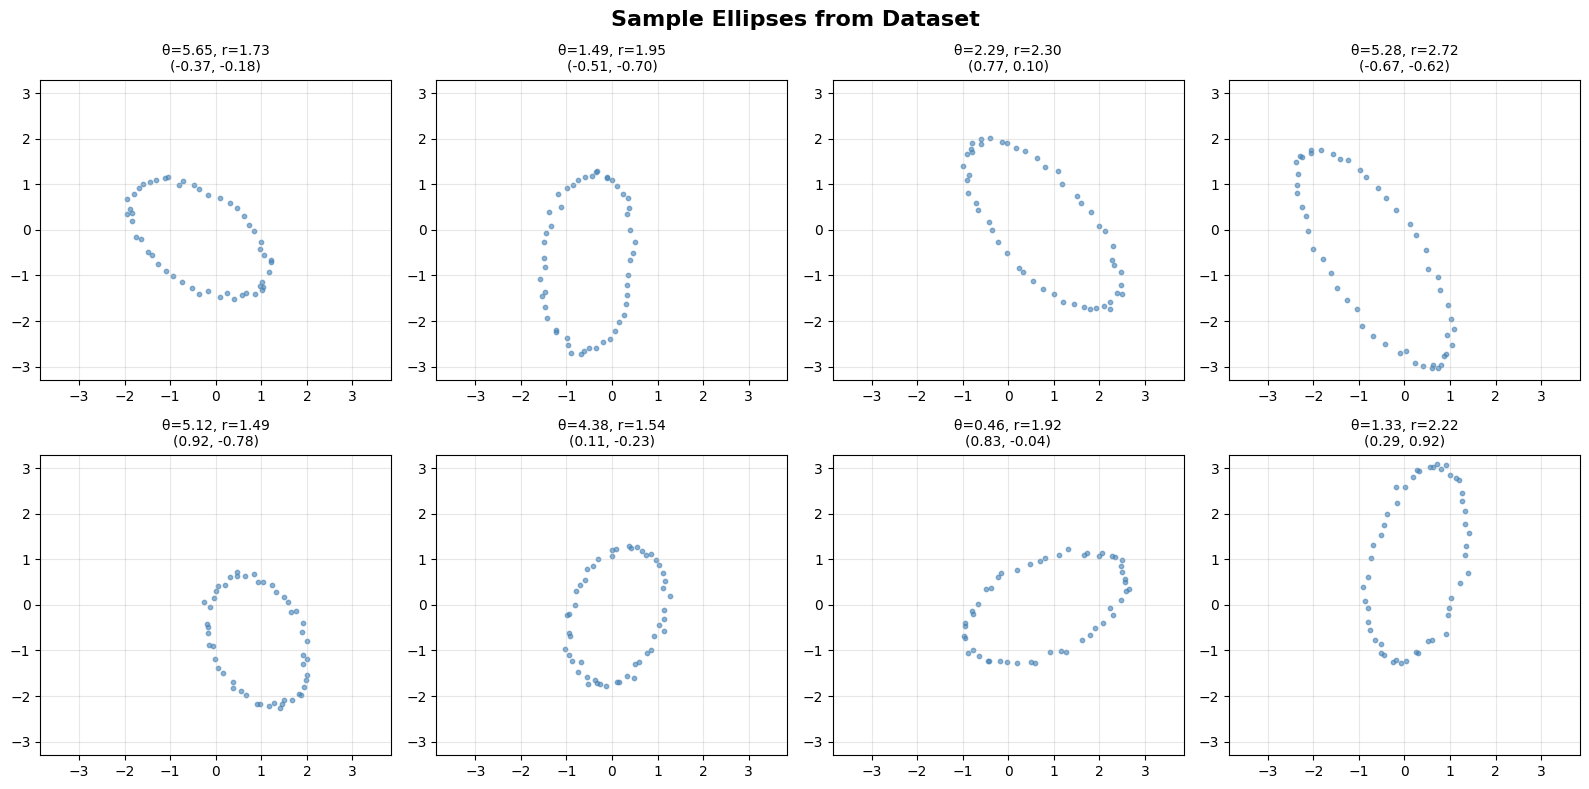

In [3]:
def visualize_ellipse_from_points(points_flat, ax=None, **kwargs):
    """Visualize an ellipse from flattened point array."""
    points = points_flat.reshape(-1, 2)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(points[:, 0], points[:, 1], **kwargs)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    return ax

# Visualize some examples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    idx = np.random.randint(0, len(X_data))
    visualize_ellipse_from_points(X_data[idx], ax=axes[i], s=10, alpha=0.6, c='steelblue')
    
    rot, aspect, cx, cy = true_factors[idx]
    axes[i].set_title(f'θ={rot:.2f}, r={aspect:.2f}\n({cx:.2f}, {cy:.2f})', fontsize=10)
    axes[i].set_xlim([-4, 4])
    axes[i].set_ylim([-4, 4])

plt.suptitle('Sample Ellipses from Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 3. InfoGAN Architecture

InfoGAN consists of three networks:

1. **Generator** $G(z, c)$: Takes noise $z$ and latent codes $c$, produces data
2. **Discriminator** $D(x)$: Distinguishes real from fake
3. **Q Network** $Q(x)$: Predicts latent codes $c$ from data $x$ (shares weights with $D$)

### Latent Code Structure

For our ellipse data, we'll use **4 continuous codes** (InfoGAN should discover they correspond to rotation, aspect ratio, and position):
- $c_1$ (continuous)
- $c_2$ (continuous)
- $c_3$ (continuous)
- $c_4$ (continuous)

In [4]:
class InfoGANGenerator(nn.Module):
    """
    Generator for InfoGAN: G(z, c) -> x
    
    Args:
        noise_dim: Dimension of incompressible noise z
        code_dim: Dimension of latent codes c (continuous)
        data_dim: Dimension of output data
        hidden_sizes: List of hidden layer sizes
    """
    def __init__(
        self,
        noise_dim: int,
        code_dim: int,
        data_dim: int,
        hidden_sizes: List[int],
        dropout: float = 0.0,
    ):
        super().__init__()
        self.noise_dim = noise_dim
        self.code_dim = code_dim
        
        # Build network
        input_dim = noise_dim + code_dim
        layers = []
        prev_dim = input_dim
        
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, data_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            z: Noise of shape (batch_size, noise_dim)
            c: Latent codes of shape (batch_size, code_dim)
        
        Returns:
            Generated data of shape (batch_size, data_dim)
        """
        gen_input = torch.cat([z, c], dim=1)
        return self.net(gen_input)


class InfoGANDiscriminator(nn.Module):
    """
    Discriminator for InfoGAN: D(x) -> logit
    Also extracts features for Q network.
    
    Args:
        data_dim: Dimension of input data
        hidden_sizes: List of hidden layer sizes
    """
    def __init__(
        self,
        data_dim: int,
        hidden_sizes: List[int],
        dropout: float = 0.1,
    ):
        super().__init__()
        
        # Shared feature extractor
        layers = []
        prev_dim = data_dim
        
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h
        
        self.features = nn.Sequential(*layers)
        
        # Discriminator head
        self.disc_head = nn.Linear(prev_dim, 1)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Data of shape (batch_size, data_dim)
        
        Returns:
            logits: Discriminator logits of shape (batch_size,)
            features: Extracted features for Q network of shape (batch_size, hidden_size)
        """
        features = self.features(x)
        logits = self.disc_head(features).view(-1)
        return logits, features


class QNetwork(nn.Module):
    """
    Q Network: Q(x) -> c
    Predicts latent codes from generated samples.
    Takes features from discriminator.
    
    Args:
        feature_dim: Dimension of features from discriminator
        code_dim: Dimension of continuous latent codes
    """
    def __init__(self, feature_dim: int, code_dim: int):
        super().__init__()
        self.code_dim = code_dim
        
        # For continuous codes, predict mean (we assume fixed variance)
        self.fc_mean = nn.Linear(feature_dim, code_dim)
    
    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """
        Args:
            features: Features from discriminator of shape (batch_size, feature_dim)
        
        Returns:
            Predicted latent codes (mean) of shape (batch_size, code_dim)
        """
        c_mean = self.fc_mean(features)
        return c_mean


def init_weights(m):
    """Initialize weights."""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


# Initialize models
noise_dim = 62  # Incompressible noise
code_dim = 4    # 4 continuous codes (rotation, aspect, center_x, center_y)
data_dim = 100  # 50 points * 2 coordinates
hidden_sizes = [256, 256, 256]

G = InfoGANGenerator(noise_dim, code_dim, data_dim, hidden_sizes).to(device)
D = InfoGANDiscriminator(data_dim, hidden_sizes).to(device)
Q = QNetwork(hidden_sizes[-1], code_dim).to(device)

G.apply(init_weights)
D.apply(init_weights)
Q.apply(init_weights)

print("InfoGAN Generator:")
print(G)
print(f"\nParameters: {sum(p.numel() for p in G.parameters()):,}")

print("\nInfoGAN Discriminator:")
print(D)
print(f"\nParameters: {sum(p.numel() for p in D.parameters()):,}")

print("\nQ Network:")
print(Q)
print(f"\nParameters: {sum(p.numel() for p in Q.parameters()):,}")

# Test forward pass
z_test = torch.randn(5, noise_dim).to(device)
c_test = torch.randn(5, code_dim).to(device)
fake_test = G(z_test, c_test)
logits_test, features_test = D(fake_test)
c_pred_test = Q(features_test)

print(f"\nTest shapes:")
print(f"  z: {z_test.shape}, c: {c_test.shape}")
print(f"  G(z,c): {fake_test.shape}")
print(f"  D(x): logits={logits_test.shape}, features={features_test.shape}")
print(f"  Q(features): {c_pred_test.shape}")

InfoGAN Generator:
InfoGANGenerator(
  (net): Sequential(
    (0): Linear(in_features=66, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=100, bias=True)
  )
)

Parameters: 174,436

InfoGAN Discriminator:
InfoGANDiscriminator(
  (features): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropo

---
## 4. Training Process

InfoGAN training involves three losses:

1. **Discriminator loss**: Standard GAN loss
2. **Generator loss**: Standard GAN loss
3. **Mutual Information loss**: $-\mathbb{E}[\log Q(c|G(z,c))]$

For continuous codes, we assume $Q(c|x) = \mathcal{N}(\mu(x), \sigma^2)$ and minimize the negative log-likelihood (MSE).

In [5]:
def train_infogan(
    data: np.ndarray,
    noise_dim: int = 62,
    code_dim: int = 4,
    hidden_sizes: List[int] = [256, 256, 256],
    batch_size: int = 128,
    n_steps: int = 30000,
    lr: float = 1e-4,
    beta1: float = 0.5,
    beta2: float = 0.999,
    lambda_mi: float = 1.0,
    real_label_smoothing: float = 0.9,
    print_every: int = 2000,
    save_samples_every: int = 3000,
    device: torch.device = device,
) -> Tuple[InfoGANGenerator, InfoGANDiscriminator, QNetwork, dict]:
    """
    Train InfoGAN.
    
    Args:
        data: Training data
        noise_dim: Dimension of noise z
        code_dim: Dimension of latent codes c
        lambda_mi: Weight for mutual information loss
    
    Returns:
        Trained G, D, Q networks and training history
    """
    data_dim = data.shape[1]
    
    # Data loader
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    G = InfoGANGenerator(noise_dim, code_dim, data_dim, hidden_sizes).to(device)
    D = InfoGANDiscriminator(data_dim, hidden_sizes).to(device)
    Q = QNetwork(hidden_sizes[-1], code_dim).to(device)
    
    G.apply(init_weights)
    D.apply(init_weights)
    Q.apply(init_weights)
    
    # Optimizers (Q shares optimizer with G)
    g_params = list(G.parameters()) + list(Q.parameters())
    g_opt = torch.optim.Adam(g_params, lr=lr, betas=(beta1, beta2))
    d_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    
    # Loss functions
    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    
    # Helper functions
    def sample_z(n):
        return torch.randn(n, noise_dim, device=device)
    
    def sample_c(n):
        # Sample from uniform [-1, 1] for continuous codes
        return torch.rand(n, code_dim, device=device) * 2 - 1
    
    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'mi_loss': [],
        'd_real': [],
        'd_fake': [],
        'samples': [],
        'codes': [],
        'steps': []
    }
    
    # Training loop
    it = iter(loader)
    for step in range(1, n_steps + 1):
        # ===== Discriminator training =====
        try:
            real = next(it)[0].to(device)
        except StopIteration:
            it = iter(loader)
            real = next(it)[0].to(device)
        
        # Generate fake samples
        z = sample_z(len(real))
        c = sample_c(len(real))
        fake = G(z, c).detach()
        
        # Discriminator predictions
        d_real_logits, _ = D(real)
        d_fake_logits, _ = D(fake)
        
        # Discriminator loss
        y_real = torch.full_like(d_real_logits, real_label_smoothing)
        y_fake = torch.zeros_like(d_fake_logits)
        
        loss_real = bce(d_real_logits, y_real)
        loss_fake = bce(d_fake_logits, y_fake)
        d_loss = loss_real + loss_fake
        
        # Update discriminator
        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()
        
        # ===== Generator + Q training =====
        z = sample_z(batch_size)
        c = sample_c(batch_size)
        fake = G(z, c)
        
        # Discriminator predictions
        g_logits, features = D(fake)
        
        # Generator loss (fool discriminator)
        y_gen = torch.ones_like(g_logits)
        g_loss = bce(g_logits, y_gen)
        
        # Mutual information loss (Q predicts c from fake)
        c_pred = Q(features)
        mi_loss = mse(c_pred, c)  # Minimize reconstruction error
        
        # Total generator loss
        total_g_loss = g_loss + lambda_mi * mi_loss
        
        # Update generator and Q
        g_opt.zero_grad()
        total_g_loss.backward()
        g_opt.step()
        
        # ===== Logging =====
        history['g_loss'].append(g_loss.item())
        history['d_loss'].append(d_loss.item())
        history['mi_loss'].append(mi_loss.item())
        history['d_real'].append(torch.sigmoid(d_real_logits).mean().item())
        history['d_fake'].append(torch.sigmoid(d_fake_logits).mean().item())
        history['steps'].append(step)
        
        if step % print_every == 0 or step == 1:
            print(f"[{step:5d}/{n_steps}] D_loss={d_loss.item():.4f} | "
                  f"G_loss={g_loss.item():.4f} | MI_loss={mi_loss.item():.4f} | "
                  f"D(real)={torch.sigmoid(d_real_logits).mean().item():.3f} | "
                  f"D(fake)={torch.sigmoid(d_fake_logits).mean().item():.3f}")
        
        # Save samples
        if step % save_samples_every == 0 or step == 1:
            with torch.no_grad():
                z_vis = sample_z(100)
                c_vis = sample_c(100)
                samples_vis = G(z_vis, c_vis).cpu().numpy()
                history['samples'].append(samples_vis)
                history['codes'].append(c_vis.cpu().numpy())
    
    return G, D, Q, history

### Train InfoGAN

In [6]:
print("Training InfoGAN...\n")
G_info, D_info, Q_info, history_info = train_infogan(
    data=X_data,
    noise_dim=62,
    code_dim=4,
    hidden_sizes=[256, 256, 256],
    batch_size=128,
    n_steps=30000,
    lr=1e-4,
    lambda_mi=1.0,
    print_every=2000,
    save_samples_every=3000,
    device=device
)
print("\nTraining complete!")

Training InfoGAN...

[    1/30000] D_loss=1.3858 | G_loss=0.6933 | MI_loss=0.3353 | D(real)=0.500 | D(fake)=0.500
[ 2000/30000] D_loss=0.5206 | G_loss=3.1004 | MI_loss=0.3552 | D(real)=0.813 | D(fake)=0.062
[ 4000/30000] D_loss=0.8531 | G_loss=2.3874 | MI_loss=0.3449 | D(real)=0.738 | D(fake)=0.172
[ 6000/30000] D_loss=0.9402 | G_loss=1.7842 | MI_loss=0.3513 | D(real)=0.670 | D(fake)=0.243
[ 8000/30000] D_loss=1.2969 | G_loss=1.0277 | MI_loss=0.3514 | D(real)=0.492 | D(fake)=0.389
[10000/30000] D_loss=1.3729 | G_loss=0.8276 | MI_loss=0.3330 | D(real)=0.473 | D(fake)=0.451
[12000/30000] D_loss=1.3715 | G_loss=0.8157 | MI_loss=0.3122 | D(real)=0.457 | D(fake)=0.449
[14000/30000] D_loss=1.3569 | G_loss=0.8159 | MI_loss=0.2775 | D(real)=0.460 | D(fake)=0.446
[16000/30000] D_loss=1.3676 | G_loss=0.8170 | MI_loss=0.2675 | D(real)=0.459 | D(fake)=0.450
[18000/30000] D_loss=1.3669 | G_loss=0.8336 | MI_loss=0.2782 | D(real)=0.459 | D(fake)=0.449
[20000/30000] D_loss=1.3481 | G_loss=0.8108 | MI_

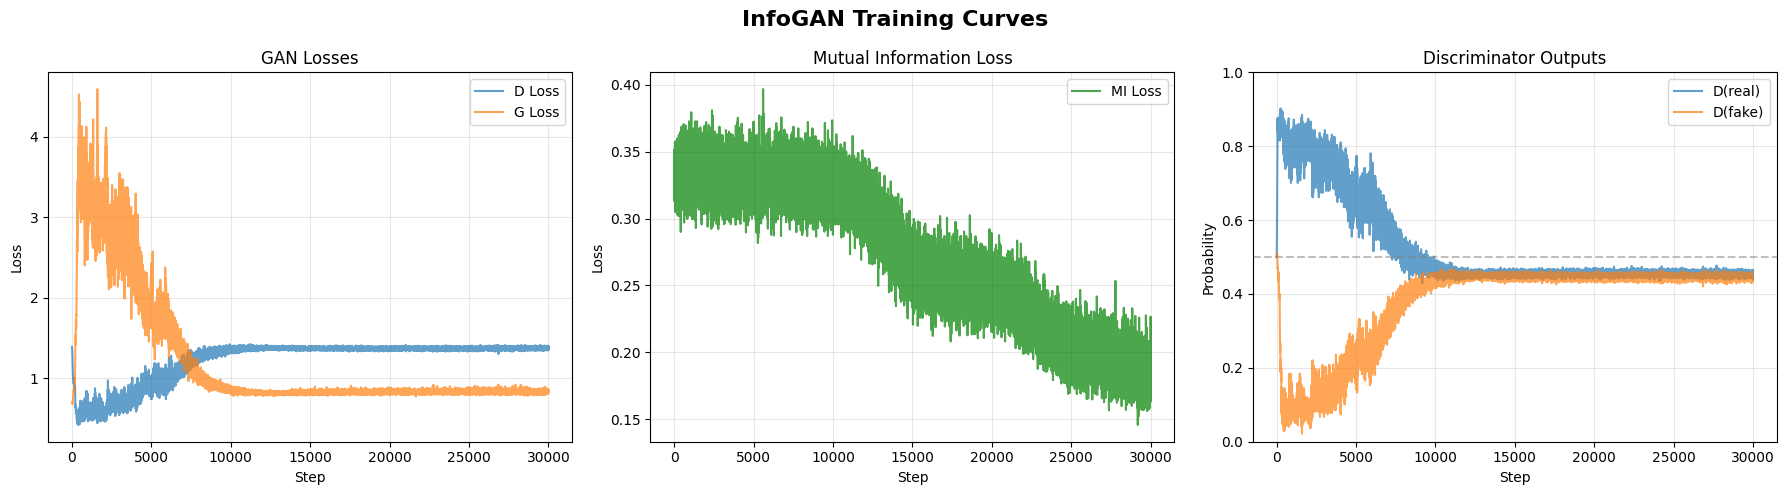

In [7]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

steps = history_info['steps']

# Losses
axes[0].plot(steps, history_info['d_loss'], label='D Loss', alpha=0.7)
axes[0].plot(steps, history_info['g_loss'], label='G Loss', alpha=0.7)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('GAN Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MI Loss
axes[1].plot(steps, history_info['mi_loss'], label='MI Loss', alpha=0.7, color='green')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Mutual Information Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Discriminator outputs
axes[2].plot(steps, history_info['d_real'], label='D(real)', alpha=0.7)
axes[2].plot(steps, history_info['d_fake'], label='D(fake)', alpha=0.7)
axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Probability')
axes[2].set_title('Discriminator Outputs')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

plt.suptitle('InfoGAN Training Curves', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Disentanglement Visualization

**The moment of truth!** Let's see if InfoGAN discovered the interpretable factors.

We'll vary **one latent code at a time** while keeping others fixed, and visualize what changes.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

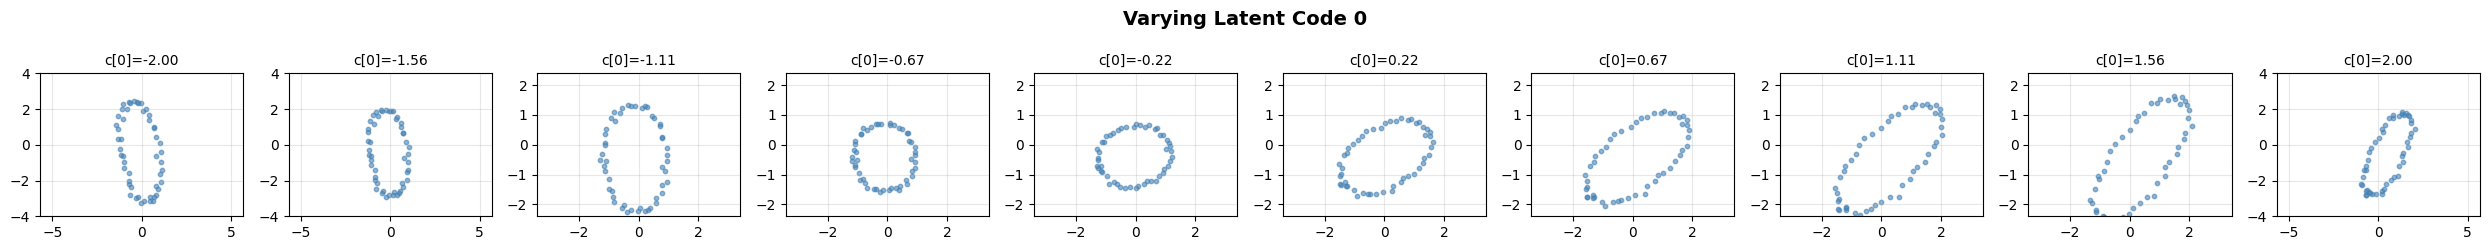

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

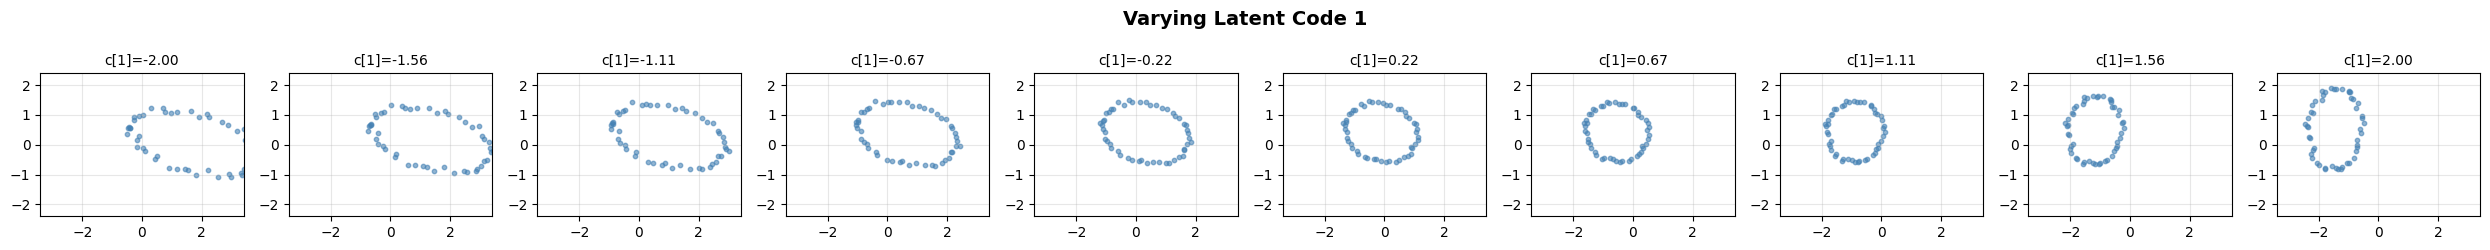

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

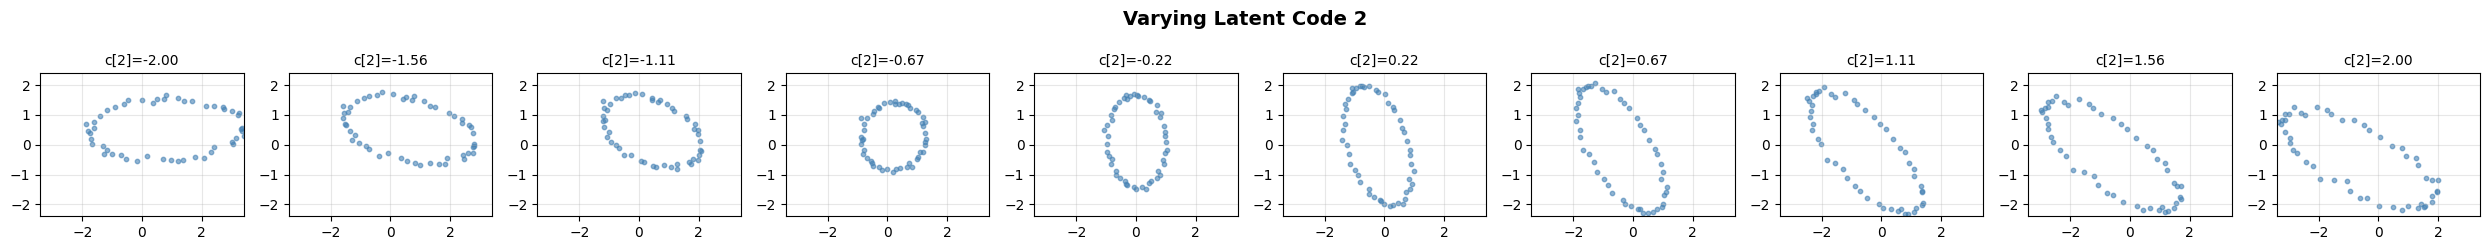

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

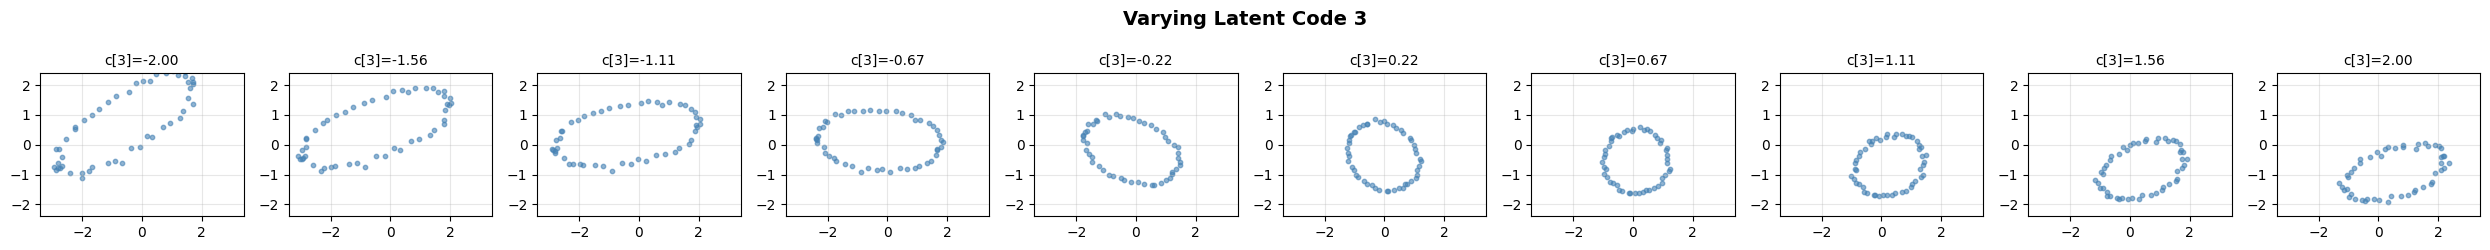

In [8]:
def visualize_code_sweep(G, code_idx, n_samples=10, device=device):
    """
    Visualize what happens when we vary one latent code.
    
    Args:
        G: Trained generator
        code_idx: Which code to vary (0, 1, 2, or 3)
        n_samples: Number of values to try
    """
    with torch.no_grad():
        # Fix noise and other codes
        z = torch.randn(1, 62, device=device).repeat(n_samples, 1)
        c = torch.zeros(n_samples, 4, device=device)
        
        # Vary the selected code from -2 to 2
        code_values = torch.linspace(-2, 2, n_samples, device=device)
        c[:, code_idx] = code_values
        
        # Generate samples
        samples = G(z, c).cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, n_samples, figsize=(2.5*n_samples, 2.5))
    
    for i, (ax, sample) in enumerate(zip(axes, samples)):
        visualize_ellipse_from_points(sample, ax=ax, s=10, alpha=0.6, c='steelblue')
        ax.set_title(f'c[{code_idx}]={code_values[i].item():.2f}', fontsize=10)
        ax.set_xlim([-4, 4])
        ax.set_ylim([-4, 4])
    
    plt.suptitle(f'Varying Latent Code {code_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize each code
for code_idx in range(4):
    visualize_code_sweep(G_info, code_idx, n_samples=10)

### 2D Grid: Varying Two Codes Simultaneously

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

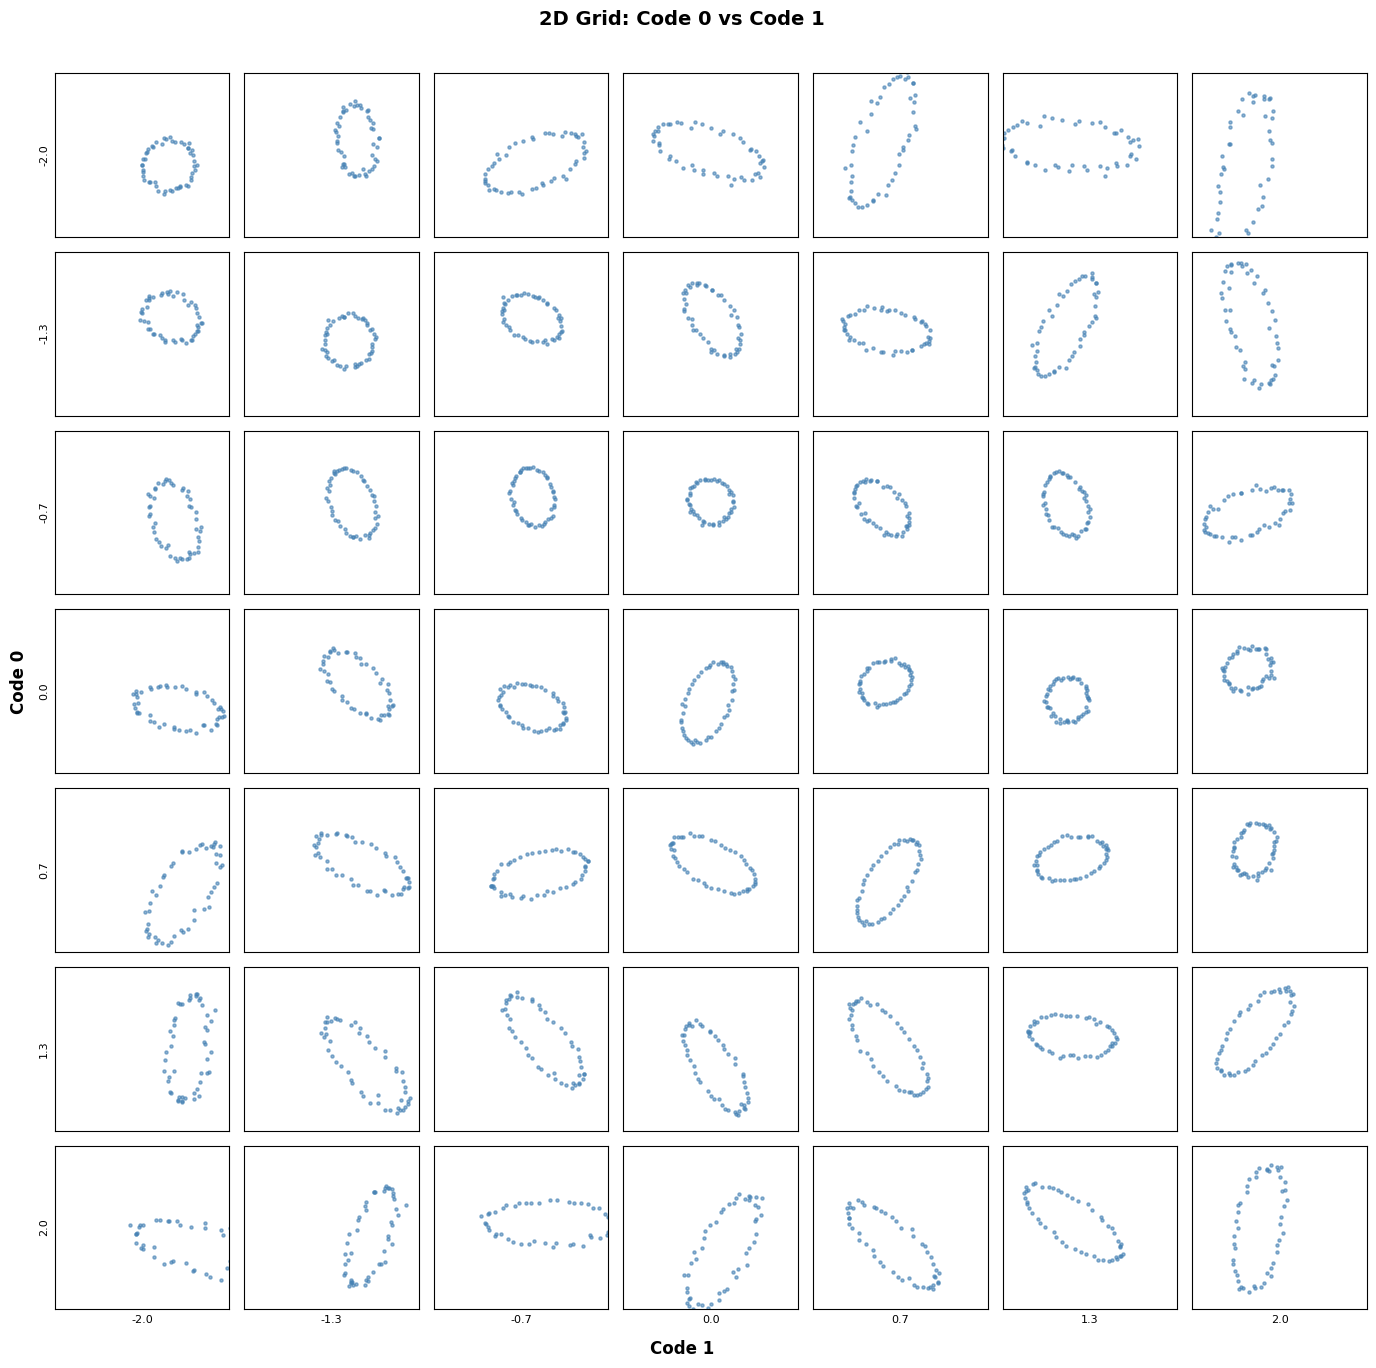

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

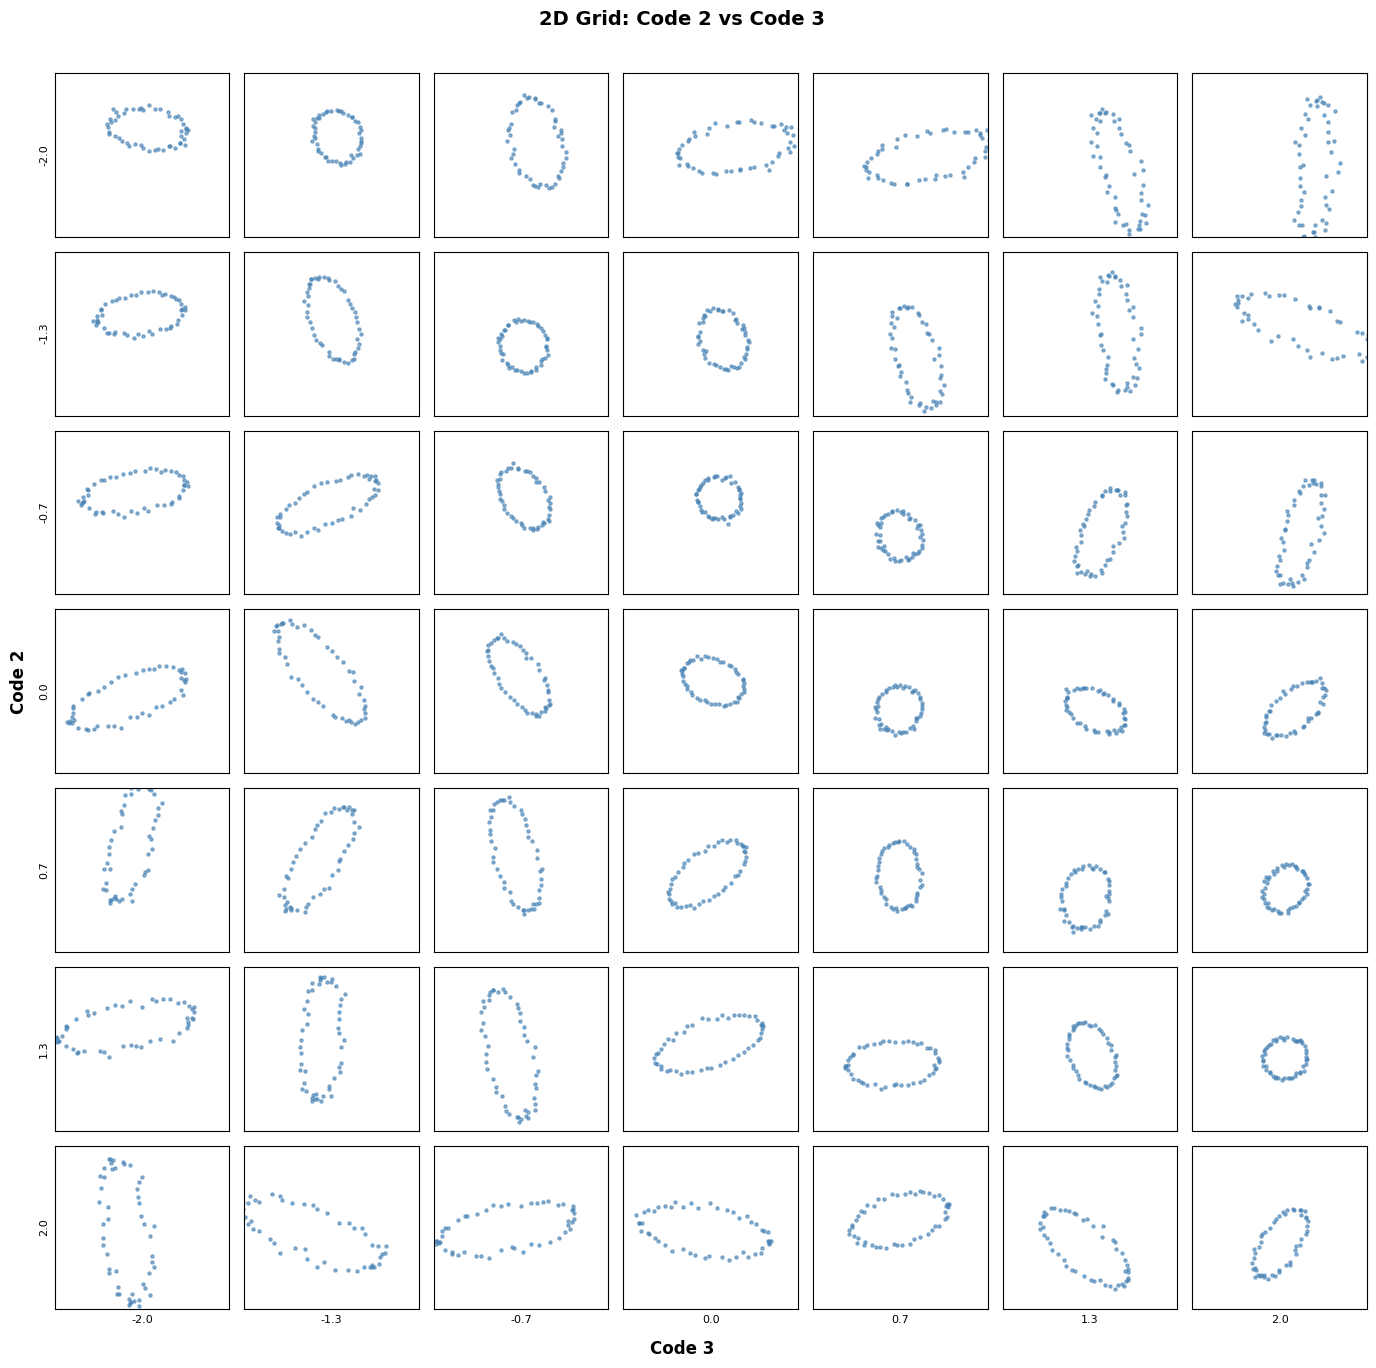

In [9]:
def visualize_2d_code_grid(G, code_idx1, code_idx2, n_points=7, device=device):
    """
    Visualize a 2D grid varying two latent codes.
    """
    with torch.no_grad():
        # Create grid
        values = torch.linspace(-2, 2, n_points, device=device)
        
        samples_grid = []
        for v1 in values:
            row = []
            for v2 in values:
                z = torch.randn(1, 62, device=device)
                c = torch.zeros(1, 4, device=device)
                c[0, code_idx1] = v1
                c[0, code_idx2] = v2
                sample = G(z, c).cpu().numpy()[0]
                row.append(sample)
            samples_grid.append(row)
    
    # Visualize
    fig, axes = plt.subplots(n_points, n_points, figsize=(2*n_points, 2*n_points))
    
    for i in range(n_points):
        for j in range(n_points):
            visualize_ellipse_from_points(samples_grid[i][j], ax=axes[i, j], 
                                         s=5, alpha=0.6, c='steelblue')
            axes[i, j].set_xlim([-4, 4])
            axes[i, j].set_ylim([-4, 4])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            
            # Labels on edges
            if j == 0:
                axes[i, j].set_ylabel(f'{values[i]:.1f}', fontsize=8)
            if i == n_points - 1:
                axes[i, j].set_xlabel(f'{values[j]:.1f}', fontsize=8)
    
    fig.text(0.5, 0.02, f'Code {code_idx2}', ha='center', fontsize=12, fontweight='bold')
    fig.text(0.02, 0.5, f'Code {code_idx1}', va='center', rotation='vertical', 
             fontsize=12, fontweight='bold')
    
    plt.suptitle(f'2D Grid: Code {code_idx1} vs Code {code_idx2}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
    plt.show()

# Show a couple of interesting 2D grids
visualize_2d_code_grid(G_info, 0, 1, n_points=7)
visualize_2d_code_grid(G_info, 2, 3, n_points=7)

---
## 6. Quantitative Evaluation

Let's quantitatively measure how well InfoGAN discovered the true factors.

We'll generate samples with known codes and check:
1. Can Q network accurately predict the codes?
2. Which discovered code corresponds to which true factor?

Correlation between true codes and predicted codes:
(Each row = one true code, each column = one predicted code)

     Pred_0  Pred_1  Pred_2  Pred_3
True_0:   0.503  -0.366   0.330  -0.201 
True_1:  -0.396   0.759   0.091   0.046 
True_2:   0.478   0.044   0.672  -0.242 
True_3:  -0.335  -0.030  -0.269   0.707 


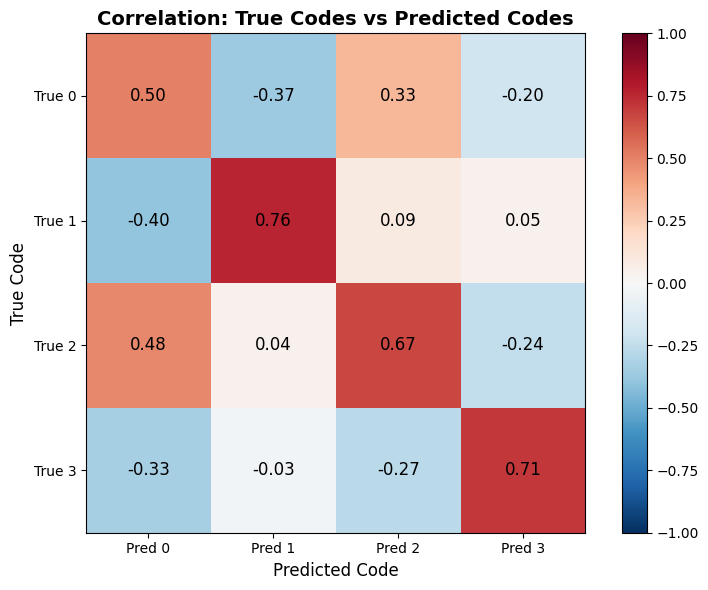


Interpretation:
High correlation (close to 1 or -1) means Q can accurately recover that code.
Diagonal values should be high if InfoGAN learned meaningful disentanglement.


In [10]:
# Generate samples with known codes
n_eval = 1000

with torch.no_grad():
    z_eval = torch.randn(n_eval, 62, device=device)
    c_eval = torch.rand(n_eval, 4, device=device) * 2 - 1  # Uniform [-1, 1]
    
    # Generate samples
    samples_eval = G_info(z_eval, c_eval)
    
    # Predict codes with Q
    _, features_eval = D_info(samples_eval)
    c_pred_eval = Q_info(features_eval)
    
    c_eval_np = c_eval.cpu().numpy()
    c_pred_np = c_pred_eval.cpu().numpy()

# Compute correlation between true and predicted codes
print("Correlation between true codes and predicted codes:")
print("(Each row = one true code, each column = one predicted code)\n")

correlation_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        correlation_matrix[i, j] = np.corrcoef(c_eval_np[:, i], c_pred_np[:, j])[0, 1]

print("     Pred_0  Pred_1  Pred_2  Pred_3")
for i in range(4):
    print(f"True_{i}: ", end="")
    for j in range(4):
        print(f"{correlation_matrix[i, j]:7.3f} ", end="")
    print()

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([f'Pred {i}' for i in range(4)])
ax.set_yticklabels([f'True {i}' for i in range(4)])
ax.set_xlabel('Predicted Code', fontsize=12)
ax.set_ylabel('True Code', fontsize=12)
ax.set_title('Correlation: True Codes vs Predicted Codes', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("High correlation (close to 1 or -1) means Q can accurately recover that code.")
print("Diagonal values should be high if InfoGAN learned meaningful disentanglement.")

### Map Discovered Codes to True Factors

Now let's see which discovered code corresponds to which true semantic factor (rotation, aspect ratio, position).


Correlation between InfoGAN codes and extracted geometric properties:
(Rows = discovered codes, Columns = true factors)

         Rotation  Aspect  Center_X  Center_Y
Code_0:    0.104    0.267    0.196   -0.114  
Code_1:    0.021   -0.103   -0.871    0.155  
Code_2:   -0.054    0.339   -0.295   -0.142  
Code_3:    0.028   -0.334    0.232   -0.419  


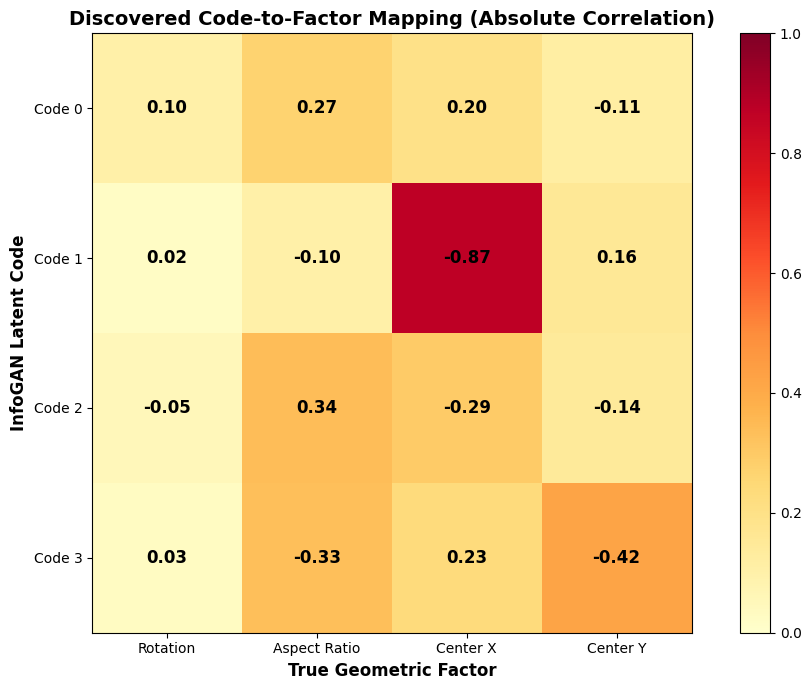


Key Insight:
Each code should have high correlation with ONE factor, showing disentanglement!
Look for which code controls rotation, aspect ratio, and position.


In [11]:
# Generate samples with systematic code variations
# and extract the actual geometric properties from the generated ellipses

def extract_ellipse_properties(points_flat):
    """
    Extract rotation, aspect ratio, and center from generated ellipse points.
    This is approximate but good enough for correlation analysis.
    """
    points = points_flat.reshape(-1, 2)
    
    # Center
    center = points.mean(axis=0)
    
    # Center the points
    centered = points - center
    
    # Use PCA to find principal axes
    cov = np.cov(centered.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # Sort by eigenvalue
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Rotation angle (angle of first principal component)
    rotation = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    if rotation < 0:
        rotation += 2 * np.pi
    
    # Aspect ratio (ratio of eigenvalues)
    aspect_ratio = np.sqrt(eigenvalues[0] / (eigenvalues[1] + 1e-8))
    
    return rotation, aspect_ratio, center[0], center[1]


# Generate samples and extract properties
n_test = 500
with torch.no_grad():
    z_test = torch.randn(n_test, 62, device=device)
    c_test = torch.rand(n_test, 4, device=device) * 2 - 1
    samples_test = G_info(z_test, c_test).cpu().numpy()
    c_test_np = c_test.cpu().numpy()

# Extract geometric properties
extracted_props = np.array([extract_ellipse_properties(s) for s in samples_test])
# Shape: (n_test, 4) - [rotation, aspect_ratio, center_x, center_y]

# Compute correlation between codes and extracted properties
print("\nCorrelation between InfoGAN codes and extracted geometric properties:")
print("(Rows = discovered codes, Columns = true factors)\n")

factor_names = ['Rotation', 'Aspect Ratio', 'Center X', 'Center Y']
code_to_factor_corr = np.zeros((4, 4))

for i in range(4):  # InfoGAN codes
    for j in range(4):  # True factors
        code_to_factor_corr[i, j] = np.corrcoef(c_test_np[:, i], extracted_props[:, j])[0, 1]

print("         Rotation  Aspect  Center_X  Center_Y")
for i in range(4):
    print(f"Code_{i}:  ", end="")
    for j in range(4):
        print(f"{code_to_factor_corr[i, j]:7.3f}  ", end="")
    print()

# Visualize
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(np.abs(code_to_factor_corr), cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(factor_names)
ax.set_yticklabels([f'Code {i}' for i in range(4)])
ax.set_xlabel('True Geometric Factor', fontsize=12, fontweight='bold')
ax.set_ylabel('InfoGAN Latent Code', fontsize=12, fontweight='bold')
ax.set_title('Discovered Code-to-Factor Mapping (Absolute Correlation)', 
             fontsize=14, fontweight='bold')

# Add text annotations
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, f'{code_to_factor_corr[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("Each code should have high correlation with ONE factor, showing disentanglement!")
print("Look for which code controls rotation, aspect ratio, and position.")

---
## 7. Interactive Experiments

### Experiment 1: Effect of λ (MI Weight)

Comparing different MI loss weights (lambda)...

Training with lambda=0.1...
[    1/10000] D_loss=1.3877 | G_loss=0.6933 | MI_loss=0.3249 | D(real)=0.499 | D(fake)=0.500
[ 5000/10000] D_loss=0.9162 | G_loss=1.9851 | MI_loss=0.3503 | D(real)=0.681 | D(fake)=0.252
[10000/10000] D_loss=1.3451 | G_loss=0.8616 | MI_loss=0.3244 | D(real)=0.456 | D(fake)=0.424

Training with lambda=0.5...
[    1/10000] D_loss=1.3862 | G_loss=0.6933 | MI_loss=0.3054 | D(real)=0.500 | D(fake)=0.500
[ 5000/10000] D_loss=1.1034 | G_loss=1.4723 | MI_loss=0.3430 | D(real)=0.595 | D(fake)=0.289
[10000/10000] D_loss=1.3558 | G_loss=0.8686 | MI_loss=0.3220 | D(real)=0.467 | D(fake)=0.442

Training with lambda=2.0...
[    1/10000] D_loss=1.3871 | G_loss=0.6933 | MI_loss=0.3257 | D(real)=0.500 | D(fake)=0.500
[ 5000/10000] D_loss=0.9838 | G_loss=1.5685 | MI_loss=0.3067 | D(real)=0.638 | D(fake)=0.288
[10000/10000] D_loss=1.3169 | G_loss=0.8795 | MI_loss=0.2858 | D(real)=0.481 | D(fake)=0.425



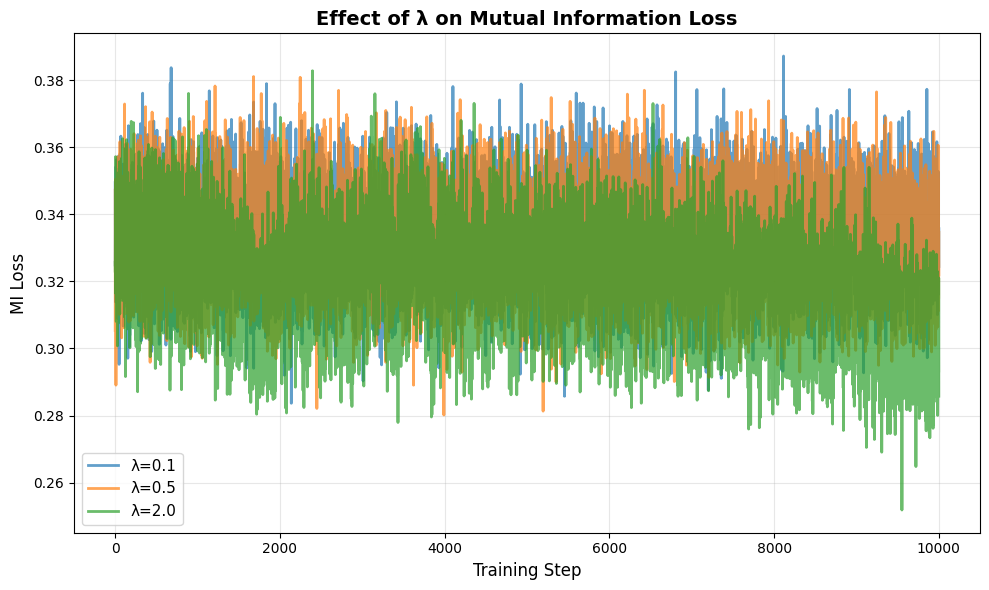

Observation: Higher λ enforces stronger mutual information, 
leading to better disentanglement but potentially affecting sample quality.


In [12]:
print("Comparing different MI loss weights (lambda)...\n")

lambda_values = [0.1, 0.5, 2.0]
lambda_results = {}

for lam in lambda_values:
    print(f"Training with lambda={lam}...")
    G_lam, D_lam, Q_lam, hist_lam = train_infogan(
        data=X_data,
        n_steps=10000,
        lambda_mi=lam,
        print_every=5000,
        save_samples_every=10000,
    )
    lambda_results[lam] = (G_lam, hist_lam)
    print()

# Compare MI loss convergence
fig, ax = plt.subplots(figsize=(10, 6))
for lam, (G, hist) in lambda_results.items():
    ax.plot(hist['steps'], hist['mi_loss'], label=f'λ={lam}', alpha=0.7, linewidth=2)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('MI Loss', fontsize=12)
ax.set_title('Effect of λ on Mutual Information Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: Higher λ enforces stronger mutual information, ")
print("leading to better disentanglement but potentially affecting sample quality.")

### Experiment 2: Interpolation in Code Space

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

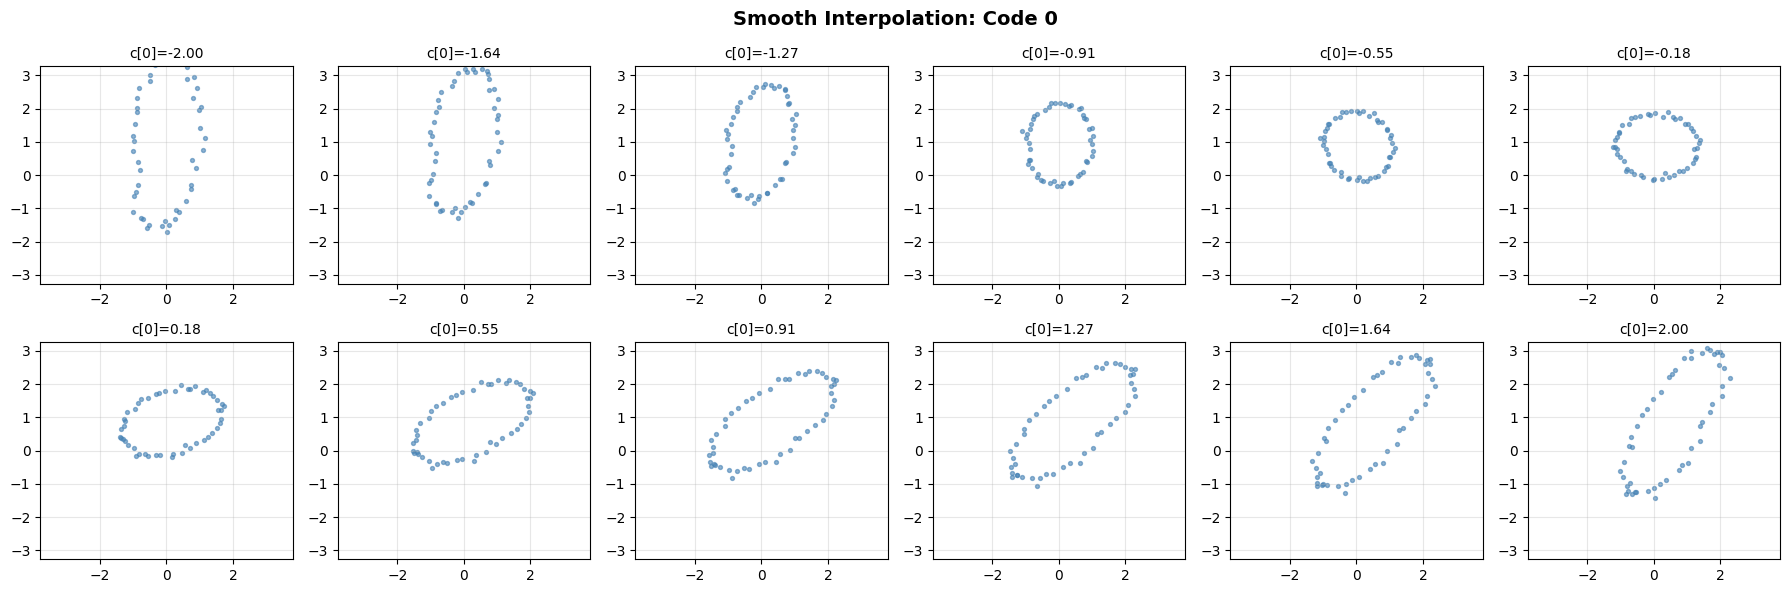

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

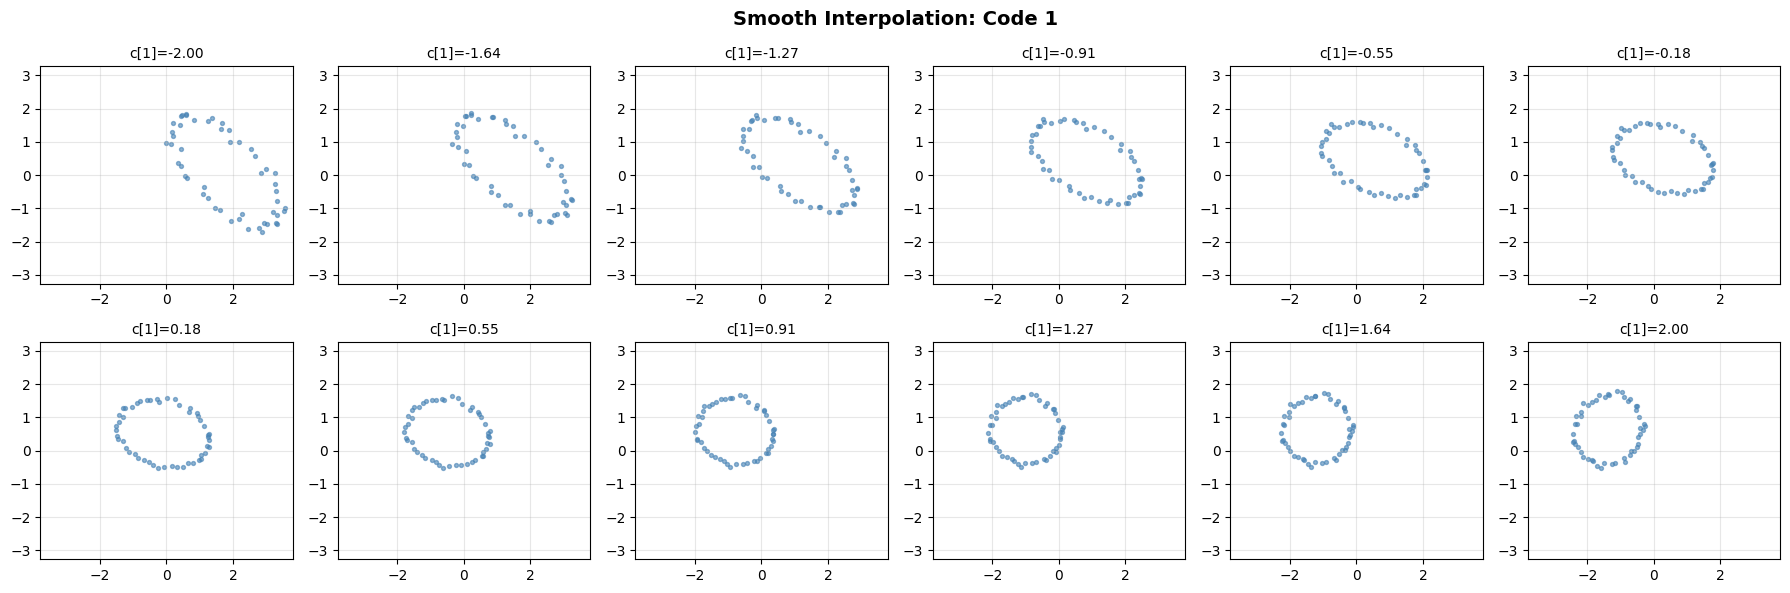

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

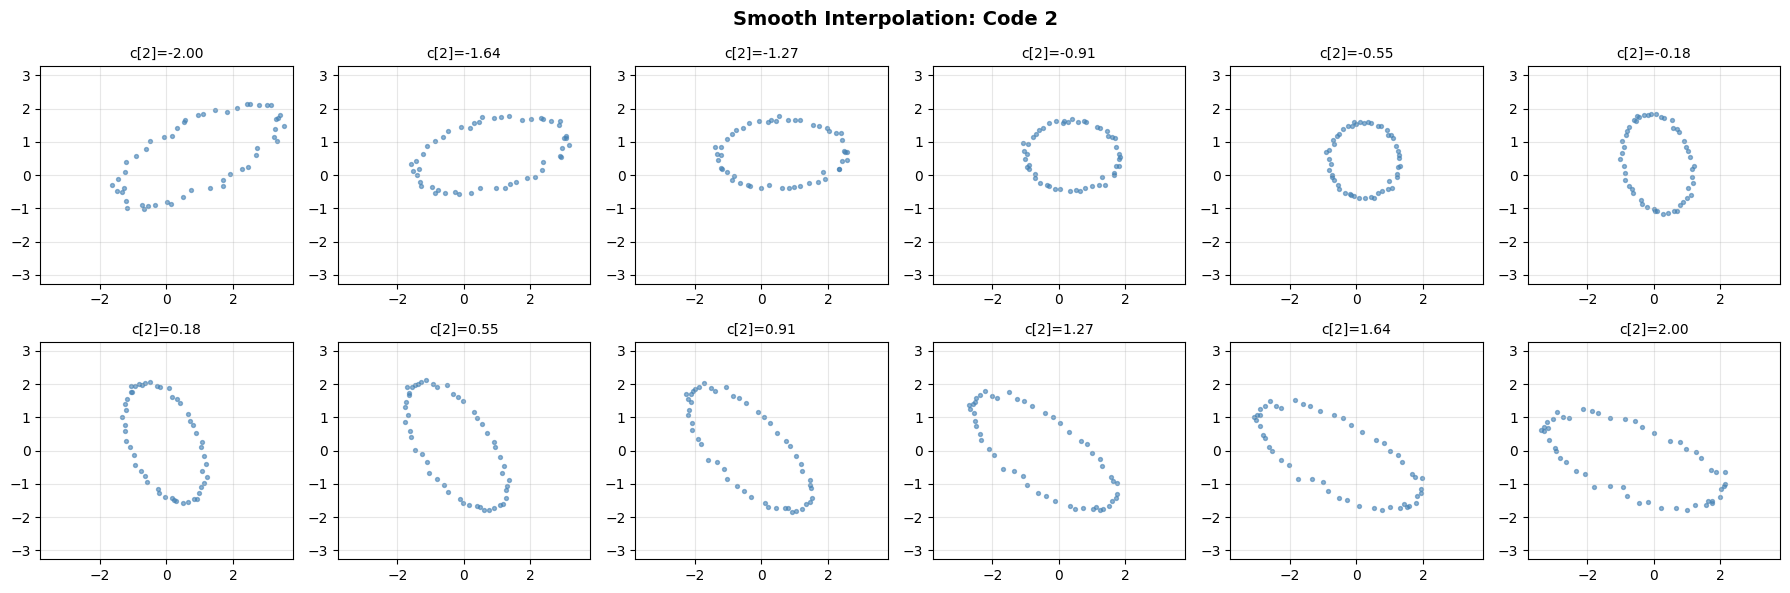

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

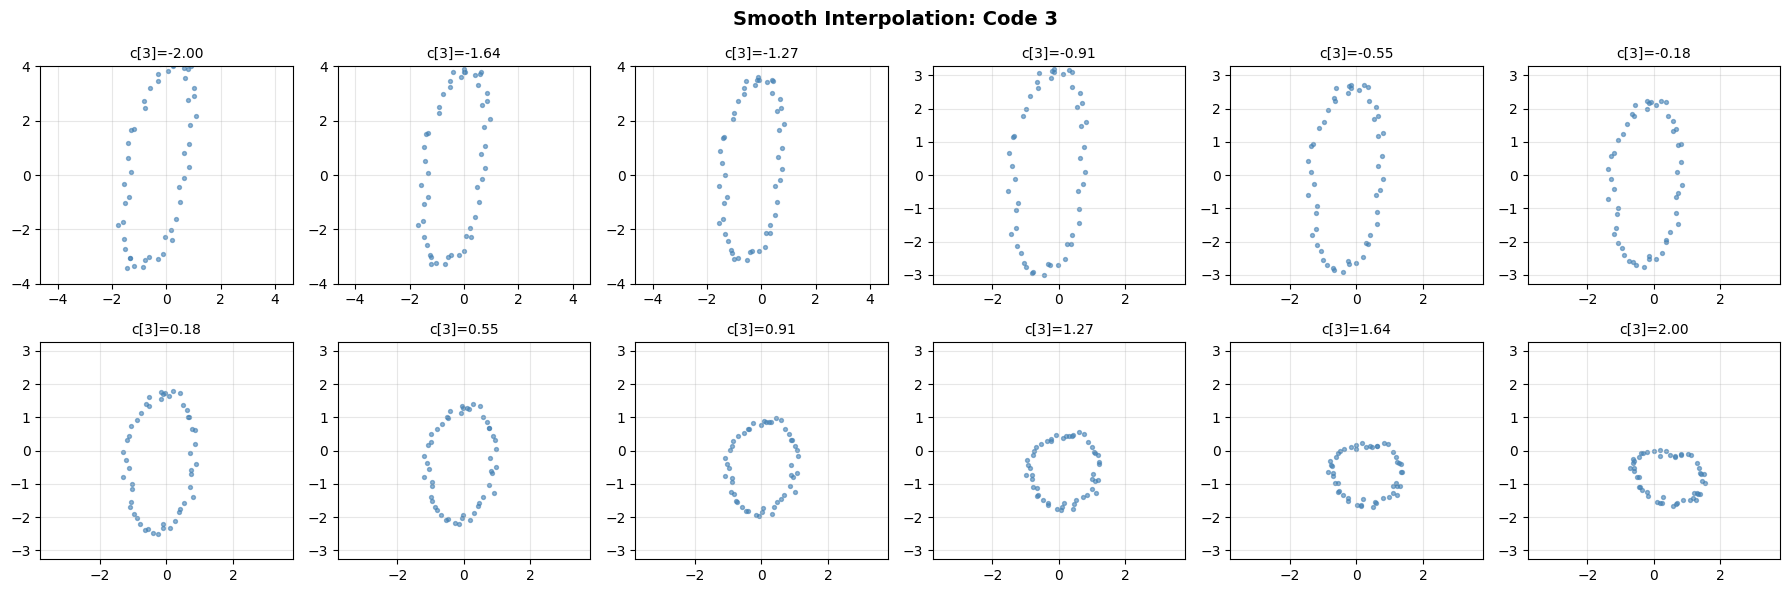

In [13]:
def interpolate_codes(code_idx, start_val=-2, end_val=2, n_steps=10, device=device):
    """
    Smoothly interpolate one code while fixing others.
    """
    with torch.no_grad():
        z = torch.randn(1, 62, device=device).repeat(n_steps, 1)
        c = torch.zeros(n_steps, 4, device=device)
        
        # Interpolate the selected code
        values = torch.linspace(start_val, end_val, n_steps, device=device)
        c[:, code_idx] = values
        
        samples = G_info(z, c).cpu().numpy()
    
    return samples, values.cpu().numpy()

# Create smooth interpolation visualization
for code_idx in range(4):
    samples, values = interpolate_codes(code_idx, n_steps=12)
    
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    axes = axes.flatten()
    
    for i, (ax, sample, val) in enumerate(zip(axes, samples, values)):
        visualize_ellipse_from_points(sample, ax=ax, s=8, alpha=0.6, c='steelblue')
        ax.set_title(f'c[{code_idx}]={val:.2f}', fontsize=10)
        ax.set_xlim([-4, 4])
        ax.set_ylim([-4, 4])
    
    plt.suptitle(f'Smooth Interpolation: Code {code_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 8. Comparison: InfoGAN vs Vanilla GAN vs cGAN

Let's compare the three approaches:
- **Vanilla GAN**: No control, entangled latent space
- **Conditional GAN**: Supervised control via labels
- **InfoGAN**: Unsupervised discovery of interpretable factors

In [14]:
# Create summary comparison
comparison_data = [
    ['Approach', 'Supervision', 'Disentanglement', 'Control', 'Key Benefit'],
    ['Vanilla GAN', 'None', 'No', 'No', 'Simple, stable training'],
    ['Conditional GAN', 'Labels required', 'Yes (supervised)', 'Yes (via labels)', 'Full control with labels'],
    ['InfoGAN', 'None', 'Yes (unsupervised)', 'Yes (via codes)', 'Discovers factors automatically']
]

print("\n" + "="*100)
print(" " * 35 + "GAN COMPARISON")
print("="*100)
print()

# Print table
col_widths = [15, 20, 25, 20, 35]
for i, row in enumerate(comparison_data):
    row_str = ""
    for j, (cell, width) in enumerate(zip(row, col_widths)):
        row_str += cell.ljust(width)
    print(row_str)
    if i == 0:
        print("-" * 100)

print("="*100)
print("\nKey Takeaway:")
print("InfoGAN provides the best of both worlds - controllable generation WITHOUT requiring labels!")


                                   GAN COMPARISON

Approach       Supervision         Disentanglement          Control             Key Benefit                        
----------------------------------------------------------------------------------------------------
Vanilla GAN    None                No                       No                  Simple, stable training            
Conditional GANLabels required     Yes (supervised)         Yes (via labels)    Full control with labels           
InfoGAN        None                Yes (unsupervised)       Yes (via codes)     Discovers factors automatically    

Key Takeaway:
InfoGAN provides the best of both worlds - controllable generation WITHOUT requiring labels!


### Visual Comparison: Latent Space Structure

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Visualizing latent space structure...



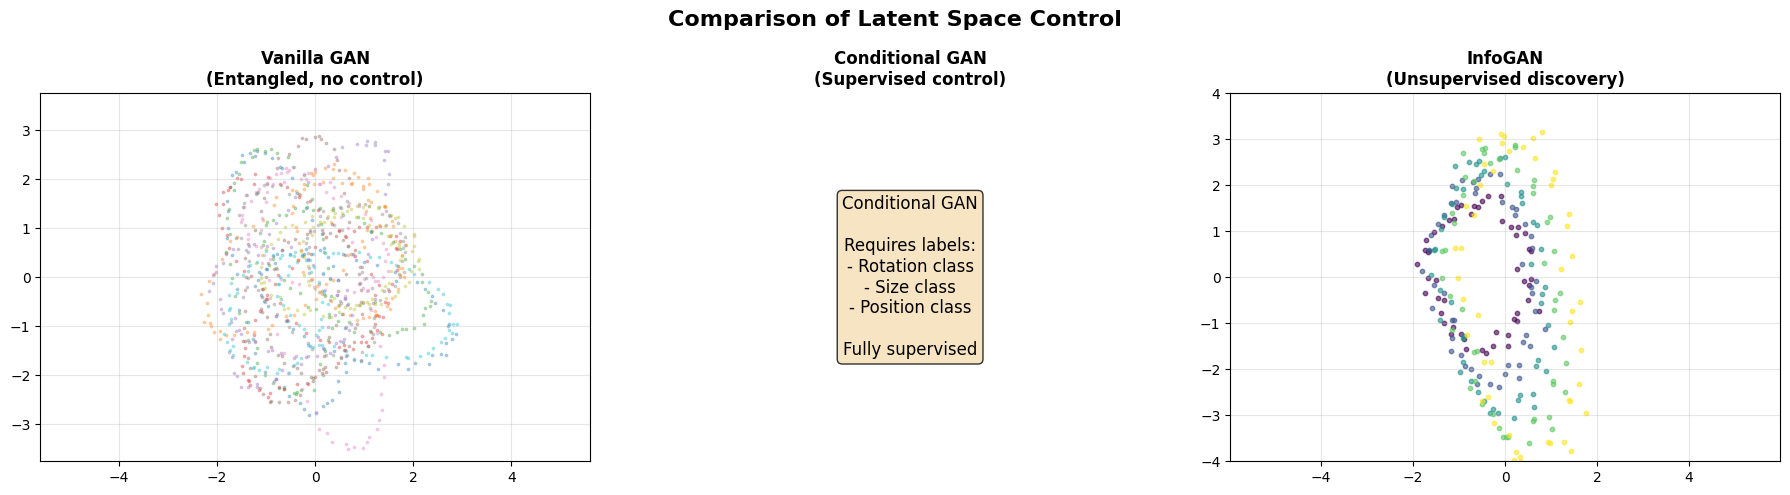

In [15]:
print("Visualizing latent space structure...\n")

fig = plt.figure(figsize=(18, 5))

# Vanilla GAN (random samples)
ax1 = fig.add_subplot(131)
for i in range(20):
    idx = np.random.randint(0, len(X_data))
    visualize_ellipse_from_points(X_data[idx], ax=ax1, s=3, alpha=0.3)
ax1.set_title('Vanilla GAN\n(Entangled, no control)', fontsize=12, fontweight='bold')
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

# cGAN (would need labels)
ax2 = fig.add_subplot(132)
ax2.text(0.5, 0.5, 'Conditional GAN\n\nRequires labels:\n- Rotation class\n- Size class\n- Position class\n\nFully supervised',
         ha='center', va='center', fontsize=12, transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax2.set_title('Conditional GAN\n(Supervised control)', fontsize=12, fontweight='bold')
ax2.axis('off')

# InfoGAN (show controlled generation)
ax3 = fig.add_subplot(133)
with torch.no_grad():
    z_demo = torch.randn(1, 62, device=device).repeat(5, 1)
    c_demo = torch.zeros(5, 4, device=device)
    c_demo[:, 0] = torch.linspace(-1.5, 1.5, 5, device=device)  # Vary first code
    samples_demo = G_info(z_demo, c_demo).cpu().numpy()

colors_demo = plt.cm.viridis(np.linspace(0, 1, 5))
for i, (sample, color) in enumerate(zip(samples_demo, colors_demo)):
    visualize_ellipse_from_points(sample, ax=ax3, s=10, alpha=0.6, c=[color])
ax3.set_title('InfoGAN\n(Unsupervised discovery)', fontsize=12, fontweight='bold')
ax3.set_xlim([-4, 4])
ax3.set_ylim([-4, 4])

plt.suptitle('Comparison of Latent Space Control', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()